# Simulate the motion of particles under strictly Brownian motion, or with a chemoattractant

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import warnings

def chemoattractant_gradient_linear(x, y):
    """
    Calculates the concentration of the chemoattractant for a linear gradient.

    Args:
        x: x-coordinate.
        y: y-coordinate.

    Returns:
        Concentration of the chemoattractant.
    """
    return x  # Linear gradient along the x-axis

def chemoattractant_gradient_radial(x, y, offset=(-0.5,-0.5)):
    """
    Calculates the concentration of the chemoattractant for a radial gradient 
    in the upper right corner.

    Args:
        x: x-coordinate.
        y: y-coordinate.

    Returns:
        Concentration of the chemoattractant.
    """
    # Calculate distance from the upper right corner
    distance = np.sqrt((x + offset[0])**2 + (y + offset[1])**2)
    return 1 - distance

def calculate_chemotaxis_bias(x, y, gradient_function,offset=(-0.5,-0.5)):
  """
  Calculates the bias in movement direction due to the chemoattractant gradient.

  Args:
    x: x-coordinate.
    y: y-coordinate.
    gradient_function: The function to use for calculating the gradient.

  Returns:
    A tuple representing the bias in the x and y directions.
  """
  # Calculate gradient components (approximation)
  dx = gradient_function(x + 0.1, y, offset) - gradient_function(x, y,offset)
  dy = gradient_function(x, y + 0.1, offset) - gradient_function(x, y,offset)

  # Normalize the gradient vector
  gradient_magnitude = np.sqrt(dx**2 + dy**2)
  if gradient_magnitude > 0:
    dx /= gradient_magnitude
    dy /= gradient_magnitude

  return dx, dy

def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #  [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #  [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #  ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [6]:
from concurrent.futures import ThreadPoolExecutor

def optimized_simulation():
    grid_res = 500
    x = np.linspace(grid_min, grid_max, grid_res)
    y = np.linspace(grid_min, grid_max, grid_res)
    X, Y = np.meshgrid(x, y)

    # Calculate chemoattractant concentration (precompute gradient once)
    Z = gradient_function(X, Y, offset)

    # Create the first plot (chemotaxis gradient)
    plt.figure(figsize=(8, 6))
    CS = plt.contourf(X, Y, Z, 20, cmap='viridis')
    plt.colorbar(label='Chemoattractant Concentration')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Chemoattractant Gradient')

    # Define simulation function for a single particle
    def simulate_particle(_):
        x = np.random.uniform(grid_min, grid_max)
        y = np.random.uniform(grid_min, grid_max)
        positions = np.zeros((num_steps + 1, 2))
        positions[0] = [x, y]

        for step in range(1, num_steps + 1):
            # Calculate chemotaxis bias
            bias_x, bias_y = calculate_chemotaxis_bias(x, y, gradient_function,offset)

            # Generate random step with bias
            step_x = np.random.uniform(-step_size, step_size) + bias_x * chemotaxis_strength
            step_y = np.random.uniform(-step_size, step_size) + bias_y * chemotaxis_strength

            x += step_x
            y += step_y
            positions[step] = [x, y]

        return positions

    # Parallelize particle simulations
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(simulate_particle, range(num_simulations)))

    # Plot particle trajectories on a single plot
    plt.figure(figsize=(8, 6))
    for positions in results:    
        x_coords= positions[:,0]
        y_coords=positions[:,1]
        timepoints = np.linspace(0, 1, len(x_coords))
        colored_line(x_coords, y_coords, timepoints, plt.gca(), linewidth=2, cmap="viridis")

    plt.xlim(grid_min, grid_max)
    plt.ylim(grid_min, grid_max)
    plt.title("Particle Trajectories")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



## Simulate the motion of 50 particles using brownian motion.
-The gradient is calculated and displayed but has zero strength

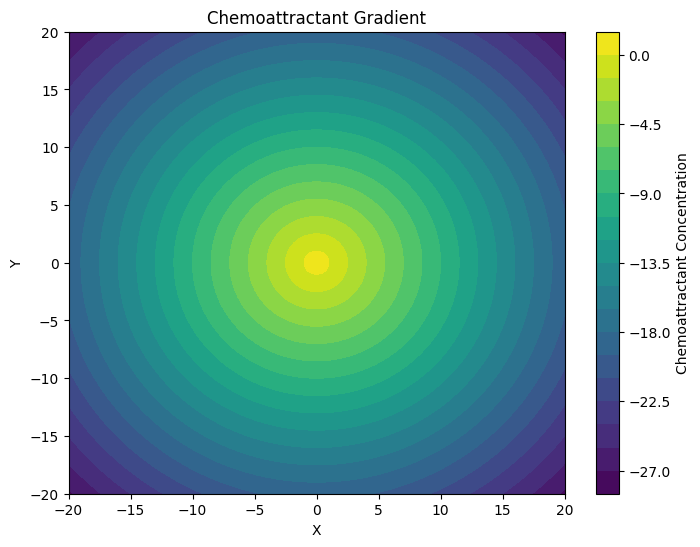

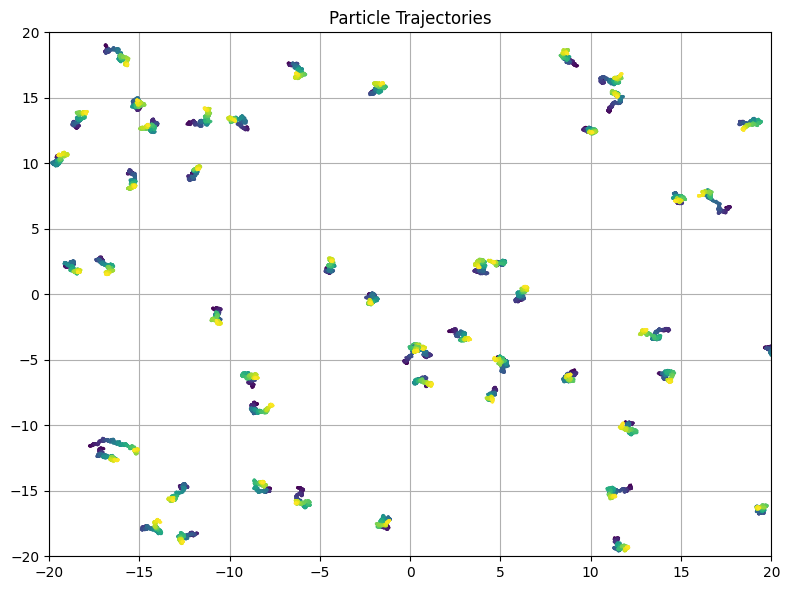

In [10]:
# Simulation parameters
num_steps = 2000
step_size = 0.025
chemotaxis_strength = 0.0  # Adjust this value to control the strength of chemotaxis
offset=(0,0)
num_simulations = 50  # Number of simulations to run

# Choose gradient function (linear or radial)
gradient_function = chemoattractant_gradient_radial  # Or chemoattractant_gradient_linear

# Set bounds for random starting positions
grid_min, grid_max = -20, 20
optimized_simulation()

![rookie](data/peaky-blinders-rookie-members.gif)
## Simulate the motion of 1000 particles using brownian motion.

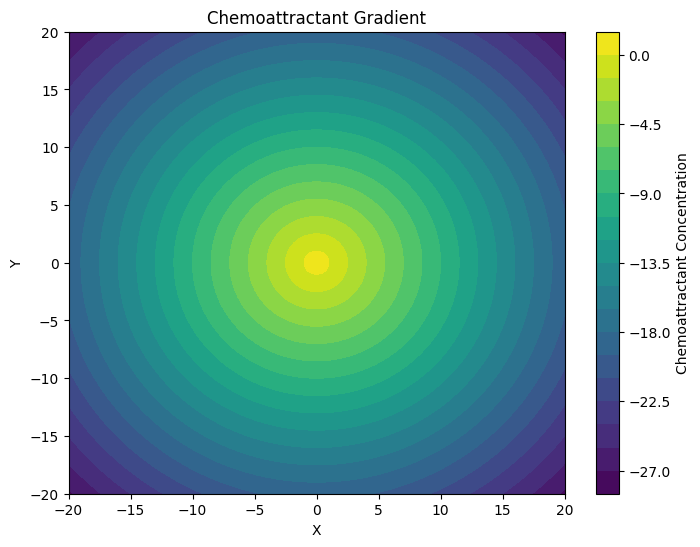

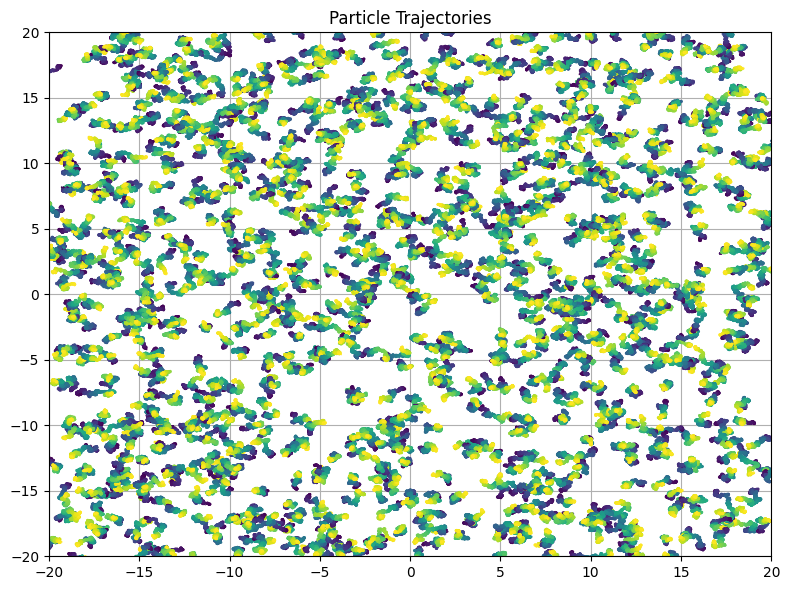

In [11]:
# Simulation parameters
num_steps = 2000
step_size = 0.025
chemotaxis_strength = 0.0  # Adjust this value to control the strength of chemotaxis
offset=(0,0)
num_simulations = 1000  # Number of simulations to run

# Choose gradient function (linear or radial)
gradient_function = chemoattractant_gradient_radial  # Or chemoattractant_gradient_linear

# Set bounds for random starting positions
grid_min, grid_max = -20, 20
optimized_simulation()

![magnet](data/crazy-in-love-magnet.gif)
## Simulate the motion of 50 particles using brownian motion with a chemoattractant.

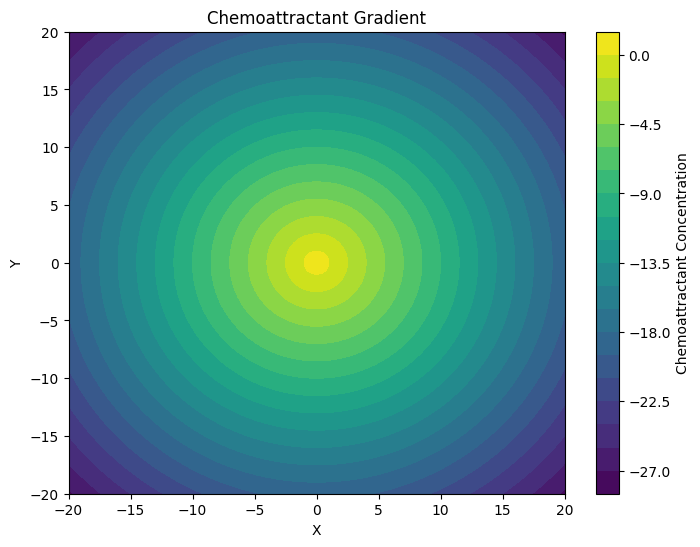

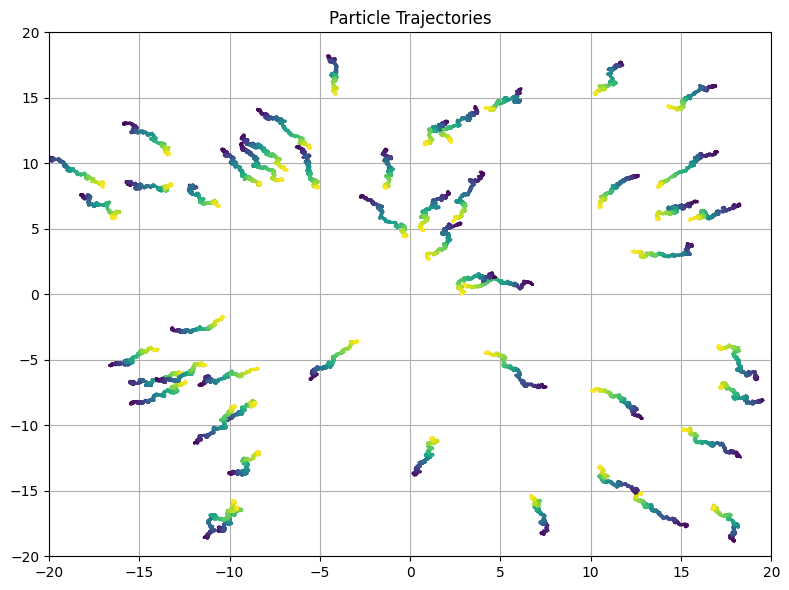

In [12]:
# Simulation parameters
num_steps = 2000
step_size = 0.025
chemotaxis_strength = 0.0015  # Adjust this value to control the strength of chemotaxis
offset=(0,0)
num_simulations = 50  # Number of simulations to run

# Choose gradient function (linear or radial)
gradient_function = chemoattractant_gradient_radial  # Or chemoattractant_gradient_linear

# Set bounds for random starting positions
grid_min, grid_max = -20, 20
optimized_simulation()

## Let's see moaaar
![moaar](data/altitude-colorado.gif)

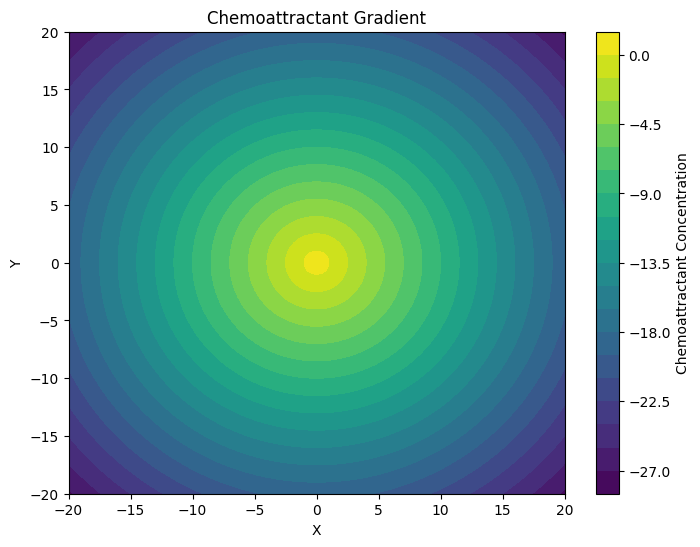

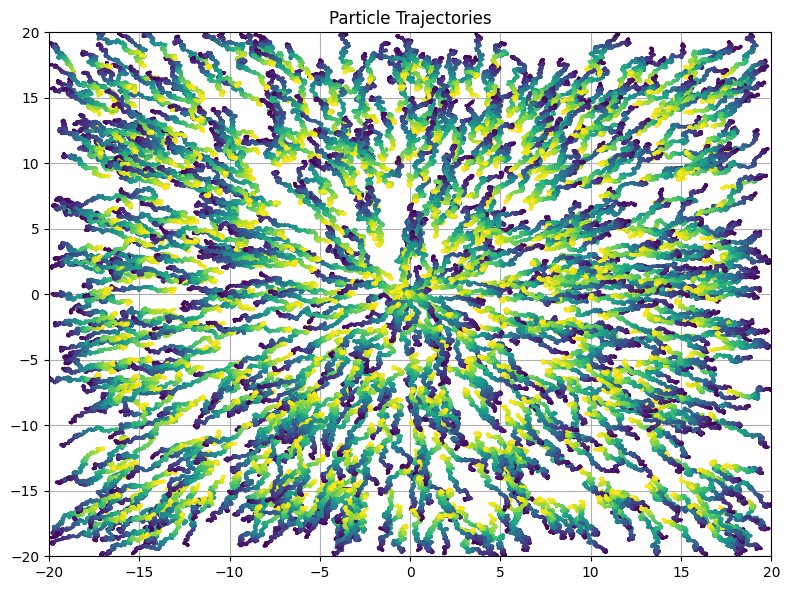

In [13]:
# Simulation parameters
num_steps = 2000
step_size = 0.025
chemotaxis_strength = 0.0015  # Adjust this value to control the strength of chemotaxis
offset=(0,0)
num_simulations = 1000  # Number of simulations to run

# Choose gradient function (linear or radial)
gradient_function = chemoattractant_gradient_radial  # Or chemoattractant_gradient_linear

# Set bounds for random starting positions
grid_min, grid_max = -20, 20
optimized_simulation()

![SlideLeft](./data/milgatetyler-dogecoin.gif)

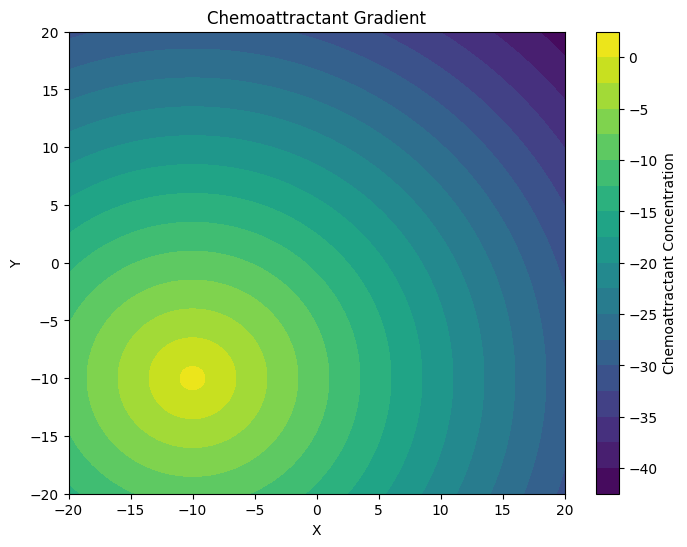

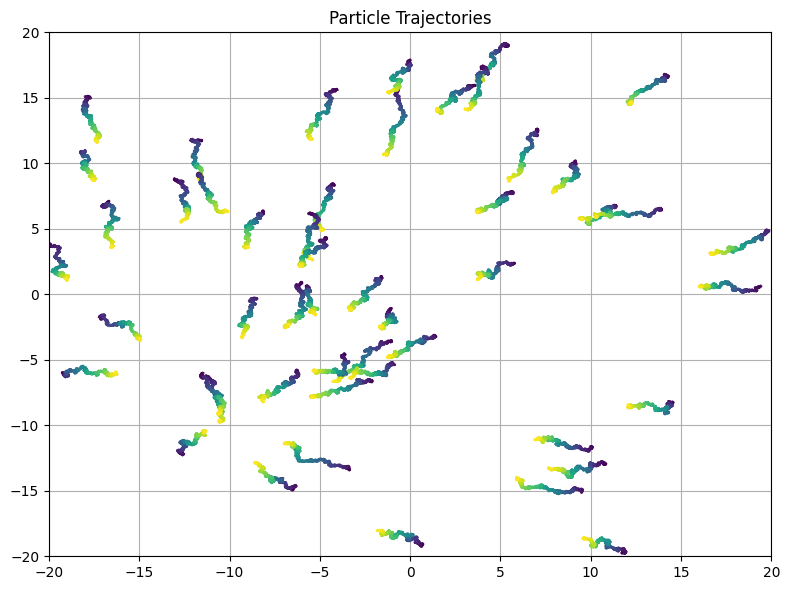

In [14]:
# Simulation parameters
num_steps = 2000
step_size = 0.025
chemotaxis_strength = 0.0015  # Adjust this value to control the strength of chemotaxis
offset=(10,10)
num_simulations = 50  # Number of simulations to run

# Choose gradient function (linear or radial)
gradient_function = chemoattractant_gradient_radial  # Or chemoattractant_gradient_linear

# Set bounds for random starting positions
grid_min, grid_max = -20, 20
optimized_simulation()

![Swarm](data/leo-movie-swarm.gif)

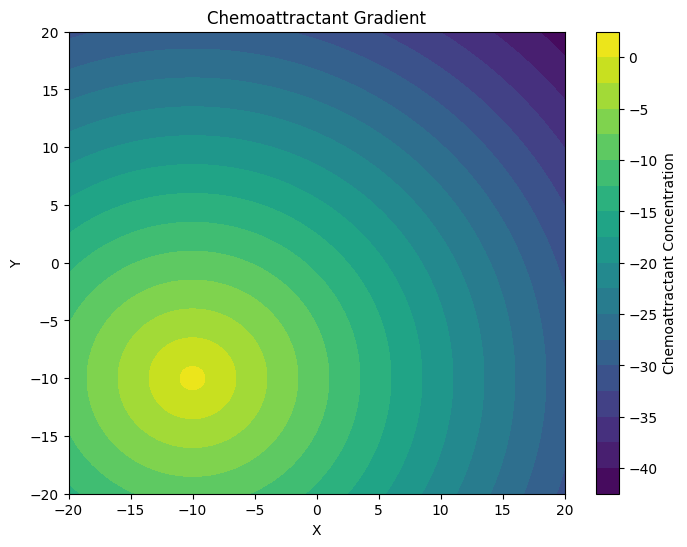

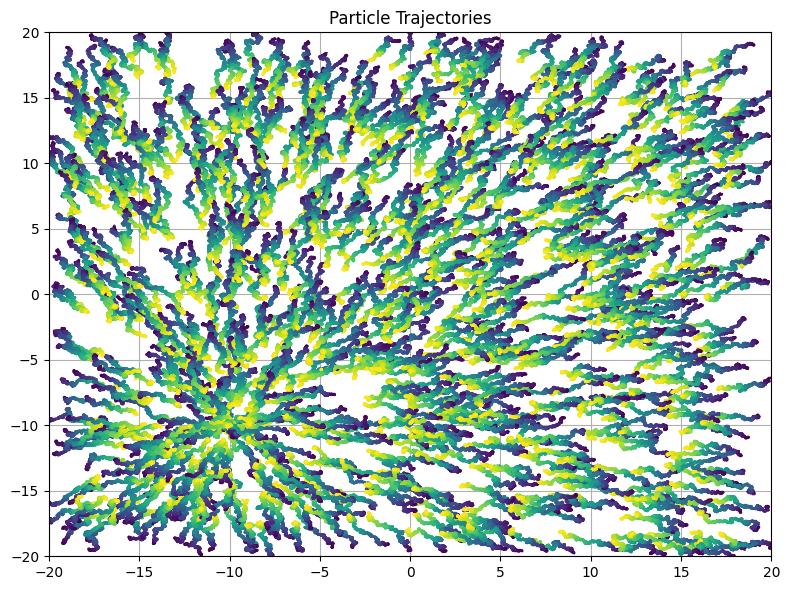

In [15]:
# Simulation parameters
num_steps = 2000
step_size = 0.025
chemotaxis_strength = 0.0015  # Adjust this value to control the strength of chemotaxis
offset=(10,10)
num_simulations = 1000  # Number of simulations to run

# Choose gradient function (linear or radial)
gradient_function = chemoattractant_gradient_radial  # Or chemoattractant_gradient_linear

# Set bounds for random starting positions
grid_min, grid_max = -20, 20
optimized_simulation()

![EwwDavid](./data/ewwdavid.gif)

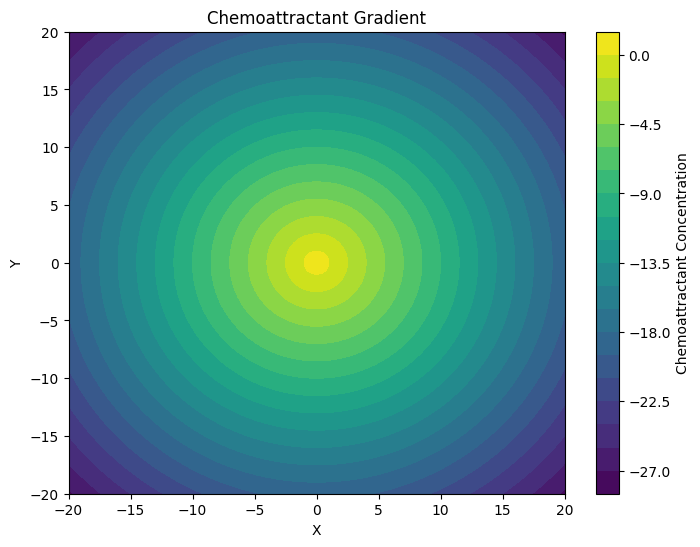

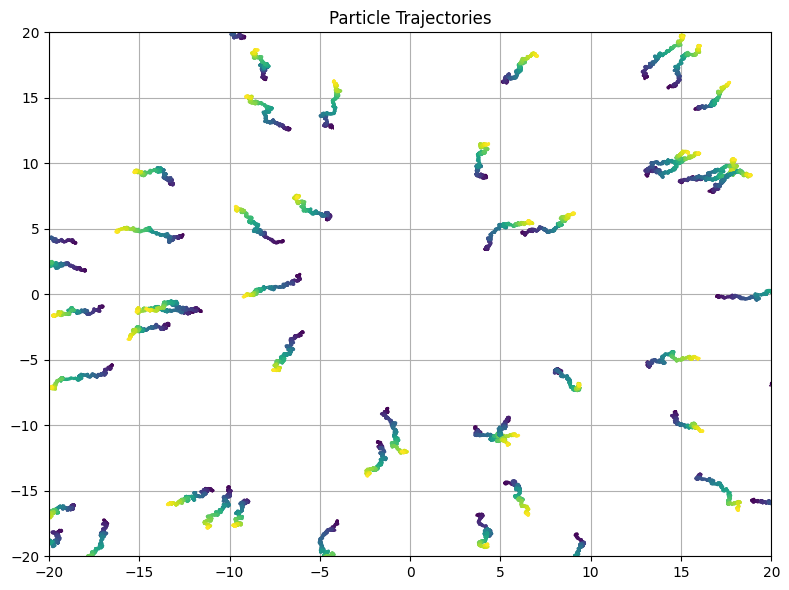

In [16]:
# Simulation parameters
num_steps = 2000
step_size = 0.025
chemotaxis_strength = -0.0015  # Adjust this value to control the strength of chemotax
offset=(0,0)
num_simulations = 50  # Number of simulations to run

# Choose gradient function (linear or radial)
gradient_function = chemoattractant_gradient_radial  # Or chemoattractant_gradient_linear

# Set bounds for random starting positions
grid_min, grid_max = -20, 20
optimized_simulation()

## Do I smell or something?

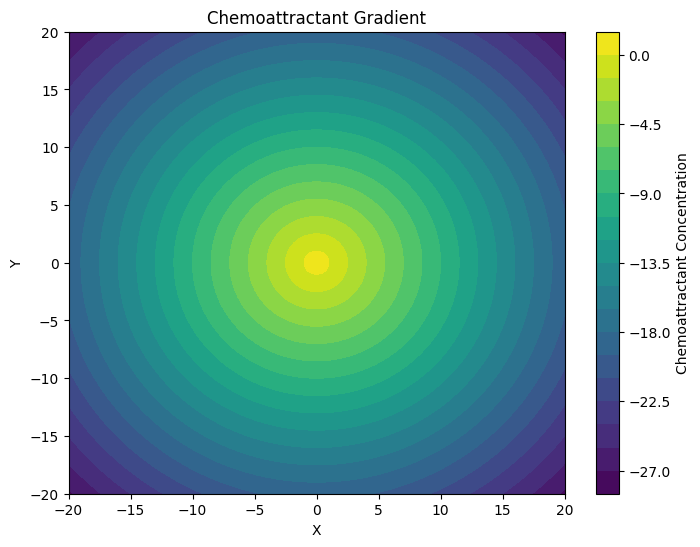

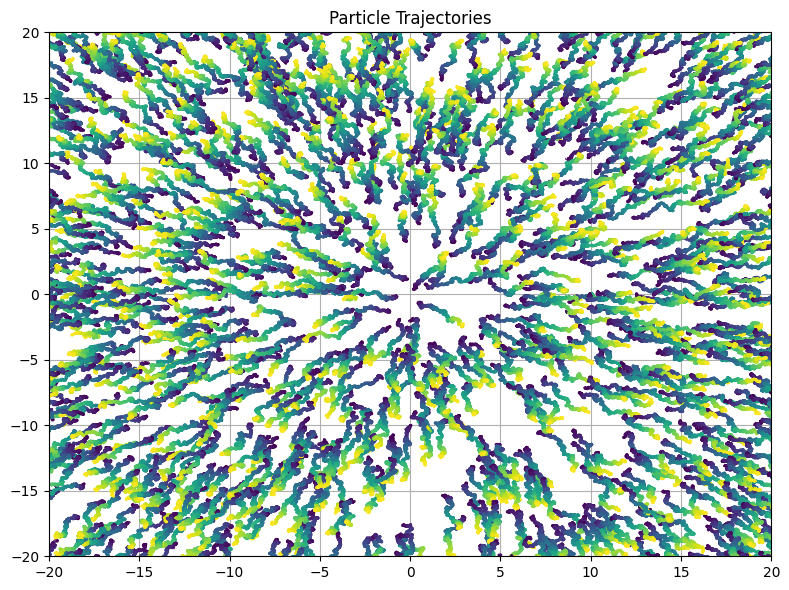

In [17]:
# Simulation parameters
num_steps = 2000
step_size = 0.025
chemotaxis_strength = -0.0015  # Adjust this value to control the strength of chemotaxis
offset=(0,0)
num_simulations = 1000  # Number of simulations to run

# Choose gradient function (linear or radial)
gradient_function = chemoattractant_gradient_radial  # Or chemoattractant_gradient_linear

# Set bounds for random starting positions
grid_min, grid_max = -20, 20
optimized_simulation()